In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
from scipy import linalg
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

<ipython-input-1-e40b24965044>:21: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [37]:
# load coolers
clr_L3 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK15_JK89_JK90_30_2000_raw.cool")


In [36]:
# load tracks
# active track is required
track_active = pyBigWig.open("/home/kimj50/modencode/H3K27ac_N2_L3_5054_mod4_input_mod2_ratio.bw")

# load as many tracks as you want to plot under saddleplot
track_inactive = pyBigWig.open("/home/kimj50/modencode/H3K27me3_N2_L3_5045_mod11_input_mod9_ratio.bw")
track_dpy27 = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v4/L3_rescale_ratio_bw_avg/N2_JK64.N2_JK65.N2_JK66.bedgraph_MAPQ1_ratio_L3_rescale_Acenter.bw")


In [6]:
#### center subregions ####
center=bioframe.read_table('/home/kimj50/ce10_sub/center.bed',schema='bed3')
center=bioframe.parse_regions(center)
center

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,chrom,start,end,name
0,I,4640000,10120000,I:4640000-10120000
1,II,4690000,11880000,II:4690000-11880000
2,III,4310000,9865000,III:4310000-9865000
3,IV,6740000,12050000,IV:6740000-12050000
4,V,8170000,13830000,V:8170000-13830000
5,X,4050000,15750000,X:4050000-15750000


In [87]:
#### functions ####

# region: bed3 as shown above, saddle plot will be generated for each row of the bed file
# nbins: number of quantiles for saddle plot
# activebw: this is used to flip eigenvector, ie pearson corr. activebw and eigenvec > 0
# otherbw_lst: list of bws to add under saddle plot, if none, simply reuse activebw
# output: list of the following, 
#     element 0 = bins quantiled by sorted eigenvector
#     element 1 = histogram of the number of bins for each quantile (theoretically equal across unless something went wrong)
#     element 2 = x-axis of histogram
#     element 3 = cooltools.saddle.make_saddle output #1, sum of contacts corrosponding to each quantile
#     element 4 = the number of elements of the above sum. element3/element4 gives you saddle plot
#     element 5 = COMP score, (AA+BB)/(AB+BA) or (topLeft+bottomRight)/(topRight+bottomLeft) quadrants of saddleplot

def eigdecomp_saddle_v2(clr,region,nbins,activebw,otherbw_lst):
    np.seterr(divide='ignore', invalid='ignore')
    chrom = "".join(['chr', region['chrom'][0]])
    clr_region = clr.bins().fetch(region['chrom'].item())
    lst_region = [clr_region['start'],clr_region['end']]
    binnify_bw = []
    for i in range(0,len(lst_region[0])):
        v = activebw.stats(chrom,
                           lst_region[0].reset_index(drop=True)[i],
                           lst_region[1].reset_index(drop=True)[i],
                           type='mean',nBins=1)[0]
        binnify_bw.append(v)
    clr_region['bw'] = binnify_bw
    
    ###########################################
    for j in range(len(otherbw_lst)):
        anotherbw = otherbw_lst[j]
        bwlabel = 'bw' + str(j)
        binnify_bw = []
        for i in range(0,len(lst_region[0])):
            v = anotherbw.stats(chrom,
                                lst_region[0].reset_index(drop=True)[i],
                                lst_region[1].reset_index(drop=True)[i],
                                type='mean',nBins=1)[0]
            binnify_bw.append(v)
        clr_region[bwlabel] = binnify_bw
        
    
    ##################
    
    
    lam,eig = cooltools.eigdecomp.cooler_cis_eig(clr=clr,
                                          bins=clr_region,
                                          regions=region,
                                          n_eigs=1,
                                          balance='weight', 
                                          ignore_diags=2,
                                          clip_percentile=99.9,
                                          sort_metric=None,phasing_track_col='bw')
    histbins=nbins
    binedges = np.linspace(0, 1, histbins)
    binedges_q = cooltools.saddle.quantile(eig['E1'], binedges)
    digitized, hist = cooltools.saddle.digitize_track(binedges_q,track=(eig, 'E1'))
    exp = cooltools.expected.diagsum(
        clr=clr,
        regions=region,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    exp['balanced.avg'] = (exp['balanced.sum'] / exp['n_valid'])
    getexp = cooltools.saddle.make_cis_obsexp_fetcher(clr, (exp,'balanced.avg'), weight_name='weight')
    int_sum,int_count = cooltools.saddle.make_saddle(getmatrix=getexp, 
                             binedges=binedges_q, 
                             digitized=(digitized,'E1.d'), 
                             contact_type='cis', regions=region, 
                             min_diag=3, max_diag=-1,
                             trim_outliers=False, verbose=False)
    COMP = cooltools.saddle.saddle_strength(int_sum, int_count)
    COMP_rescaled = (COMP-1)/(COMP+2)
    COMP_summary = {'COMP': COMP, 
                    'COMP_rescaled': COMP_rescaled,
                    'chr': ((" " + region['chrom'][0])*len(COMP)).split(),
                    'sample': str(clr)
                   }
    COMP_summary_df = pd.DataFrame(COMP_summary)
    return(digitized,hist,binedges,int_sum,int_count,COMP_summary_df)


# wrapper around above, simply groups bedfile by chromosome
def eigdecomp_saddle_perchr_v2(clr,region,nbins,activebw,otherbw_lst):
    np.seterr(divide='ignore', invalid='ignore')
    output = []
    for c in ['I','II','III','IV','V','X'] :
        print(c)
        region_c=region[region['chrom']==c].reset_index(drop=True)
        t = eigdecomp_saddle_v2(clr=clr,region=region_c,nbins=nbins,activebw=activebw,otherbw_lst=otherbw_lst)
        output.append(t)
    return(output)

def saddle_bw_E1_v2(eig_digitized,n_of_bw_lst):
    np.seterr(divide='ignore', invalid='ignore')
    x = eig_digitized.sort_values(by='E1.d')
    y = np.unique(x['E1.d'])
    col1 = ['E1','bw']
    col2 = ['bw' + str(s) for s in np.arange(n_of_bw_lst).tolist()]
    cols = list(itertools.chain(col1,col2))
    out_lst = []
    for j in range(len(cols)):
        saddle_j = []
        for i in range(len(y)):
            a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
            saddle_j.append(a)
        out_lst.append(saddle_j)
    return(out_lst)


# average saddleplots and corrosponding bigwigs of different chromosomes
# perchr_dat_eig = an element of output of eigdecomp_saddle_perchr_v2
# start_chr_element, end_chr_element = range of chr to combine 0,5 means range(0,5) or chr1-5
# n_of_bw_lst = number of bws used in 'otherbw_lst' param of above function
def saddleplot_combine_chromosomes_v2(perchr_dat_eig,start_chr_element,end_chr_element,n_of_bw_lst):
    np.seterr(invalid='ignore')
    saddle_combined = []
    bw_combined = []
    for i in range(start_chr_element,end_chr_element):
        print('combined' + str(i))
        a = perchr_dat_eig[i][3]/perchr_dat_eig[i][4]
        b = np.delete(a, (0,len(a)-1), axis=0)
        c = np.delete(b, (0,len(a)-1), axis=1)
        E1_bw = saddle_bw_E1_v2(perchr_dat_eig[i][0],n_of_bw_lst=n_of_bw_lst)
        saddle_combined.append(c)
        bw_combined.append(E1_bw)
    A = np.nanmean(np.stack(saddle_combined,axis=2),axis=2)
    B = np.nanmean(np.stack(bw_combined,axis=1),axis=1)
    dat_eig_combined = [A,B]
    
    out = []
    out.append(dat_eig_combined)
    saddle_not_combined = []
    bw_not_combined = []
    for i in range(end_chr_element,len(perchr_dat_eig)):
        print('not combined' + str(i))
        a = perchr_dat_eig[i][3]/perchr_dat_eig[i][4]
        b = np.delete(a, (0,len(a)-1), axis=0)
        c = np.delete(b, (0,len(a)-1), axis=1)
        E1_bw = saddle_bw_E1_v2(perchr_dat_eig[i][0],n_of_bw_lst=n_of_bw_lst)
        dat_eig_i = [c,E1_bw]
        out.append(dat_eig_i)
    return(out)

# find global minmax values for bws
def find_minmax_bw_global_v2(saddleplot_combined):    
    dat = saddleplot_combined
    nbw = len(dat[0][1])
    minmax_lst = []
    for i in range(nbw):
        bw_i = []
        for j in range(len(dat)):
            bw_i.append(dat[j][1][i][1:-1])
        bw_i_c = list(itertools.chain.from_iterable(bw_i))
        minmax_lst.append([min(bw_i_c),max(bw_i_c)])
    return(minmax_lst)

# used to combined left and right arm of saddle plots, eig1 and eig2 = left and right of saddleplots
# here, we use it for the format of data structure... compute_COMP assumes
def saddleplot_average_perchr_v2(eig1,eig2,n_of_bw_lst):
    np.seterr(divide='ignore', invalid='ignore')
    eigs = [eig1,eig2]
    saddle_avg = []
    bw_avg = []
    for i in range(len(eigs[0])):
        saddle_i = []
        bw_i = []
        for j in range(len(eigs)):
            a = eigs[j][i][3]/eigs[j][i][4]
            b = np.delete(a, (0,len(a)-1), axis=0)
            c = np.delete(b, (0,len(a)-1), axis=1)
            E1_bw = saddle_bw_E1_v2(eigs[j][i][0],n_of_bw_lst)
            saddle_i.append(c)
            bw_i.append(E1_bw)
        A = np.nanmean(np.stack(saddle_i,axis=2),axis=2)
        B = np.nanmean(np.stack(bw_i,axis=1),axis=1)
        saddle_avg.append(A)
        bw_avg.append(B)
    return(saddle_avg,bw_avg)


def compute_COMP(saddleMatrix):
    M = saddleMatrix # numpy 2d array
    s = len(M)
    BB1,BB2 = np.arange(0,s//2),np.arange(0,s//2)
    AA1,AA2 = np.arange(s-s//2,s),np.arange(s-s//2,s)
    BA1,BA2 = np.arange(0,s//2),np.arange(s-s//2,s)
    AB1,AB2 = np.arange(s-s//2,s),np.arange(0,s//2)
    BB = M[np.ix_(BB1, BB2)]
    AA = M[np.ix_(AA1, AA2)]
    BA = M[np.ix_(BA1, BA2)]
    AB = M[np.ix_(AB1, AB2)]
    COMP = (np.average(AA)+np.average(BB))/(np.average(AB)+np.average(BA))
    return(COMP)

def compute_COMP_saddleplot_combined(saddleplot_combine_output):
    x = saddleplot_combine_output
    chr_lst = ['I','II','III','IV','V','X']
    COMP_lst = []
    for i in range(6):
        M_i = x[0][i]
        COMP_lst.append(compute_COMP(M_i))
    df = pd.DataFrame(list(zip(chr_lst, COMP_lst)),
               columns =['chr', 'COMP'])
    return(df)


In [40]:
############################################ compartment saddle plots #########################################
sub_regions = [center] # list of regions,
track_lst = [track_inactive,track_dpy27]

eig_L3 = []
for i in range(len(sub_regions)):
    x = eigdecomp_saddle_perchr_v2(clr_L3,sub_regions[i],42,track_active,track_lst)
    eig_L3.append(x)
    


I
II
III
IV
V
X


In [68]:
##################### combine autosomes ###########################
bw_n = len(track_lst)
eig_L3_combinedA = saddleplot_combine_chromosomes_v2(eig_L3[0],0,5,bw_n)

##### find global minmax for bigwigs to plot
eig_minmax_L3 = find_minmax_bw_global_v2(eig_L3_combinedA)

combined0
combined1
combined2
combined3
combined4


<ipython-input-54-6298b7c75ddc>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-54-6298b7c75ddc>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-54-6298b7c75ddc>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-54-6298b7c75ddc>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-54-6298b7c75ddc>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])


not combined5


<ipython-input-54-6298b7c75ddc>:127: RuntimeWarning: Mean of empty slice
  B = np.nanmean(np.stack(bw_combined,axis=1),axis=1)
<ipython-input-54-6298b7c75ddc>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])


Text(0.54, 0.93, 'Embryo,center')

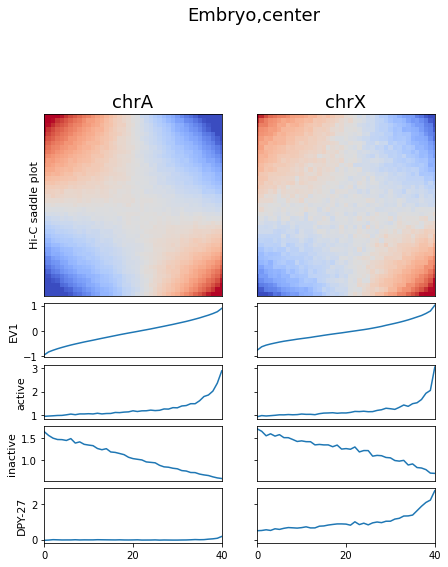

In [70]:
############################### saddle plot autosome averaged, embryo ############
f, axs = plt.subplots(
    figsize=(7, 10),
    nrows=1,
    ncols=2,
    sharex=False,
    sharey='row'
)

##### data to plot #####
dat = eig_L3_combinedA # data str: layer1=A and X, layer2=list(saddplot,activebw used to flip the eigvector,otherbws)

##### global param #####
sMin,sMax = [-0.8,0.8] # minmax for saddle plot
minmax = eig_minmax_L3 # data str: list of minmax for all bigwigs
padp = 0.05 # padding of minmax, proportional to the range (0.05=5% of range will be used to pad the yaxis)

##### global labeling #####
sub_titles = ['chrA','chrX']
sub_titles_fontsize = 18
row_labels = ['Hi-C saddle plot','EV1','active','inactive','DPY-27']
row_labels_fontsize = 11


for i in range(len(dat)): # loop through each element of dat (autosome and X)
    
    ##### saddle plot ####
    ax = axs[i]
    im = ax.matshow(np.log2(dat[i][0]),
                    cmap='coolwarm',
                    vmin=sMin,
                    vmax=sMax)


    #### saddle plot labeling ####
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_title(sub_titles[i],fontsize=sub_titles_fontsize)

    if i == 0:
        ax.set(ylabel=row_labels[0])
        ax.yaxis.label.set_size(row_labels_fontsize)
    else:
        ax.axes.get_yaxis().set_ticklabels([])
    ###############################    
    
    divider = make_axes_locatable(ax)
    xval = np.array(range(len(dat[i][0])))
    
    
    ##### bw plots ####
    for j in range(len(dat[i][1])):
        ax = divider.append_axes("bottom", size="30%", pad=0.1,sharex=ax)
        ax.plot(xval,dat[i][1][j][1:-1])
        padv = (minmax[j][1]-minmax[j][0])*padp
        ax.set_ylim([minmax[j][0]-padv,minmax[j][1]+padv])
        plt.xlim([xval.min(), xval.max()])
        
        # bigwig labeling
        if i == 0:
            ax.set(ylabel=row_labels[j+1])
            ax.yaxis.label.set_size(row_labels_fontsize)
        else:
            ax.axes.get_yaxis().set_ticklabels([])
        if j < (len(dat[i][1])-1):
            ax.xaxis.set_visible(False)
        else:
            ax.axes.set_xticks([xval.min(),xval.max()//2,xval.max()])
    
    
    
    
    
f.text(0.54, 0.93, 'Embryo,center', ha='center',fontsize=18)


In [84]:
##################### compute compartment strength #########################
# 'average region', compute_COMP assumes data structure of output of this function
eig_L3_combineRegion = saddleplot_average_perchr_v2(eig_L3[0],eig_L3[0],bw_n) # reuse same center region twice,


COMP_center = compute_COMP_saddleplot_combined(eig_L3_combineRegion)

COMP_center



<ipython-input-83-1de0403742bb>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-83-1de0403742bb>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-83-1de0403742bb>:174: RuntimeWarning: Mean of empty slice
  B = np.nanmean(np.stack(bw_i,axis=1),axis=1)
<ipython-input-83-1de0403742bb>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-83-1de0403742bb>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-83-1de0403742bb>:174: RuntimeWarning: Mean of empty slice
  B = np.nanmean(np.stack(bw_i,axis=1),axis=1)
<ipython-input-83-1de0403742bb>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-83-1de0403742bb>:104: RuntimeWarning: Mean of empty slice
  a = np.nanmean(x[cols[j]][x['E1.d']==y[i]])
<ipython-input-83-1de0403742bb>:174: RuntimeWa

,chr,COMP
0,I,1.364239
1,II,1.387042
2,III,1.391319
3,IV,1.371949
4,V,1.347329
5,X,1.252938


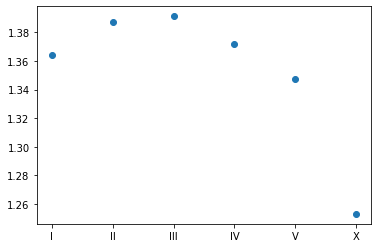

In [86]:
plt.scatter(COMP_center['chr'],COMP_center['COMP'])